<a href="https://colab.research.google.com/github/mayait/ClaseAnalisisDatos/blob/main/python101/spotify_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Vamos a conectarnos a un API externo para procesar datos en vivo de Spotify, usaremos *pandas* para serializar los datos y luego vamos a exportarlos a Excel



**Crea tu API**
1. Registrate en Spotify para obtener tus credenciales de API 
https://developer.spotify.com/dashboard/
2. Create an APP y asignale un nombre
3. Copia tus credenciales de spotify el client_ID y el SECRET





In [8]:
#@title Tus credenciales de spotify

client_id = "" #@param {type:"string"}
client_secret = "" #@param {type:"string"}


**Ahora ve a Spotify y averigua cual es tu usuario**
https://www.spotify.com/us/account/overview/

*PRO TIP: Prueba el usuario "spotify" tiene listas increibles!!*


In [2]:
#@title Ingresa tu usuario de Spotify
mi_username = "spotify" #@param {type:"string"}

In [3]:
#@title Ejecuta el setup


# Instala SPOTIPY
# pip es una herramienta que importa librerias externas que no tengas instaladas
! pip install spotipy

# Vamos a utilizar todas estas librerias
import spotipy
spotify = spotipy.Spotify()
import sys
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import requests
import lxml
import json

# Librerías para visualización
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

# Hay diferentes temas de graficos https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
matplotlib.style.use('fast') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 12.7 MB/s 
     |████████████████████████████████| 248 kB 40.4 MB/s 
     |████████████████████████████████| 62 kB 977 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
#@title Funciones para conectarse a Spotify

def get_spotify_credentials():
    # Esta funcion conecta spotify con tus credenciales
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    sp.trace = True
    return sp

def get_spotify_data(artist_name):

    # obtner la autorizaciones con espotify
    sp = get_spotify_credentials()

    # Busquemos el artista
    results = sp.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        artist = items[0]

    uri = artist['uri']

    # Obtengamos los albums
    results = sp.artist_albums(uri, album_type='album')
    albums = results['items']

    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])

    uris = []
    track_names = []
    album_names = []

    # Saquemos info de los tracks de los albums
    for album in albums:
        for t in sp.album(album['uri'])['tracks']['items']:
            uris.append(t['uri'])
            track_names.append(t['name'])
            album_names.append(album['name'])
    features = []
    for i in range(len(uris)// 100 + 1):
        fs = sp.audio_features(uris[i*100:min((i+1)*100, len(uris))])
        if fs[0] is not None:
            features.extend(fs)
    print(features)

    # Convirtamos esto a un DataFrame de Pandas!
    dat = pd.DataFrame(features)
    dat['track_name'] = track_names
    dat['album'] = album_names
    dat['artists'] = artist_name


    dat.set_index('track_name', inplace=True)
    dat.drop_duplicates(inplace=True)
    dat = dat[~dat.index.duplicated(keep='first')]

    return dat

In [5]:
#@title Función obtener playlists

def get_user_playlist(username=mi_username, sp=get_spotify_credentials()):
    playlists = sp.user_playlists(username) # Obtener todos los playlist
    while playlists['next']:
        for playlist in playlists['items']:
            print("ID: {} \t Canciones {}\t  Nombre: {} ".
                  format(playlist['id'], playlist['tracks']['total'], playlist['name']))
        playlists = sp.next(playlists)

# También podemos definir una función que obtenga los datos de la lista de reproducción de un usuario.
def get_spotify_playlist_data(username, playlist_id):

    track_number_limit = 1000     # Pongamos un limite de tracks a Analizar

    # De nuevo hagamos login en spotify
    # Ven lo util de hacer funciones, no tengo que volverlo a escribir todo!!!!
    sp = get_spotify_credentials()

    results = sp.user_playlist(username, playlist_id, fields="tracks,next")['tracks']
    
    # Mira los resultados que vienen del API
    # print(json.dumps(results, indent=4)) # Comenta esta linea despues

    tracks = results['items']
    while results['next'] and len(tracks) < track_number_limit:
        results = sp.next(results)
        if results['items'][0] is not None:
            tracks.extend(results['items'])

    ts = []
    track_names = []

    for t in tracks:
        track = t['track']
        track['album'] = track['album']['name']
        track_names.append(t['track']['name'])
        artists = []
        for a in track['artists']:
            artists.append(a['name'])
        track['artists'] = ', '.join(artists)
        ts.append(track)

    uris = []
    dat = pd.DataFrame(ts)

    dat.drop(['available_markets', 'disc_number', 'external_ids', 'external_urls'], axis=1, inplace=True)

    features = []

    for i in range(len(dat)// 100 + 1):
        fs = sp.audio_features(dat.uri.iloc[i*100:min((i+1)*100, len(dat))])
        if fs[0] is not None:
            features.extend(fs)

    fs = pd.DataFrame(features)

    dat = pd.concat([dat, fs], axis=1)
    dat['track_name'] = track_names


    dat.set_index('track_name', inplace=True)
    dat = dat[~dat.index.duplicated(keep='first')]
    dat = dat.T[~dat.T.index.duplicated(keep='first')].T

    return dat

In [ ]:
# Busquemos canciones de algun artista y guardemoslo en una variable
canciones_de_artista = get_spotify_data('Queen')

In [ ]:
# Veamos las columnas que tenemos!
print(canciones_de_artista.shape[0], "canciones")
print(canciones_de_artista.columns)

In [ ]:
canciones_de_artista.sample(3)

In [ ]:
# Exportemos el dataframe a Excel
canciones_de_artista.to_excel(r'canciones.xlsx', sheet_name='canciones', index = False)

# Canciones en una playlist

**Awsome!!!**

Como era de esperar, podemos ver que para cada pista hemos obtenido las propiedades acústicas deseadas (junto con alguna información sobre su ubicación en la base de datos de Spotify). 



**Encuentra el ID del playlist que quieres analizar entre todos tus playlists**
La siguiente función imprime tus playlists y los id de cada lista, copia en el portapapeles el ID de la playlist que quieres analizar

In [ ]:
# Esta función suele obtener tus playlists
get_user_playlist()

ID: 37i9dQZF1DXcBWIGoYBM5M 	 Canciones 50	  Nombre: Today's Top Hits 
ID: 37i9dQZF1DX0XUsuxWHRQd 	 Canciones 50	  Nombre: RapCaviar 
ID: 37i9dQZF1DX1lVhptIYRda 	 Canciones 52	  Nombre: Hot Country 
ID: 37i9dQZF1DX10zKzsJ2jva 	 Canciones 50	  Nombre: Viva Latino 
ID: 37i9dQZF1DX4JAvHpjipBk 	 Canciones 104	  Nombre: New Music Friday 
ID: 37i9dQZF1DX4sWSpwq3LiO 	 Canciones 297	  Nombre: Peaceful Piano 
ID: 37i9dQZF1DX4SBhb3fqCJd 	 Canciones 50	  Nombre: Are & Be 
ID: 37i9dQZF1DWXRqgorJj26U 	 Canciones 165	  Nombre: Rock Classics 
ID: 37i9dQZF1DX4dyzvuaRJ0n 	 Canciones 88	  Nombre: mint 
ID: 37i9dQZF1DXcF6B6QPhFDv 	 Canciones 51	  Nombre: Rock This 
ID: 37i9dQZF1DWXJfnUiYjUKT 	 Canciones 96	  Nombre: New Music Friday 
ID: 37i9dQZF1DXcRXFNfZr7Tp 	 Canciones 100	  Nombre: just hits 
ID: 37i9dQZF1DX4o1oenSJRJd 	 Canciones 150	  Nombre: All Out 2000s 
ID: 37i9dQZF1DXbTxeAdrVG2l 	 Canciones 150	  Nombre: All Out 90s 
ID: 37i9dQZF1DX4UtSsGT1Sbe 	 Canciones 150	  Nombre: All Out 80s 
ID: 37i9dQZF

ERROR:spotipy.client:Max Retries reached


SpotifyException: ignored

Voy a utilizar el playlist "This is Debussy"
37i9dQZF1DWXnRw5VvmZDb

Puedes ver un playlist en spotify usando el ID de la siguiente forma:
**https://open.spotify.com/playlist/37i9dQZF1DWXnRw5VvmZDb**

In [6]:
#@title Selecciona tu playlist
playlist_A_id = "37i9dQZF1DWXnRw5VvmZDb" #@param {type:"string"}
playlist_A_shortname = "debussy" #@param {type:"string"}
playlist_B_id = "37i9dQZF1DZ06evO4m87u0" #@param {type:"string"}
playlist_B_shortname = "TheBlackKeys" #@param {type:"string"}


In [9]:
playlist_A = get_spotify_playlist_data(username=mi_username, playlist_id=playlist_A_id)
playlist_B = get_spotify_playlist_data(username=mi_username, playlist_id=playlist_B_id)

# Mira el formato en que viene la información del API, esto es un formato JSON, es una estructura pareccida a un diccionario.

In [11]:
playlist_A.shape

(59, 29)

In [13]:
playlist_B.shape

(50, 29)

In [14]:
print(playlist_A.columns)

Index(['album', 'artists', 'duration_ms', 'episode', 'explicit', 'href', 'id',
       'is_local', 'name', 'popularity', 'preview_url', 'track',
       'track_number', 'type', 'uri', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'track_href', 'analysis_url',
       'time_signature'],
      dtype='object')


**Pasemos esto a Excel y luego a Tableau y hagamos hagamos un Dashboard de nuestro Playlist**

In [15]:
playlist_A.to_excel(playlist_A_shortname + '.xlsx', sheet_name='playlist_A', index = False)
playlist_B.to_excel(playlist_B_shortname + '.xlsx', sheet_name='playlist_B', index = False)

You can find below the explanation of each feature ( past/copy from the Spotify website).

**Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is 
acoustic. 1.0 represents high confidence the track is acoustic.
Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.
Loudness: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

**Speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

**Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [17]:
# Revisemos los tipos de datos que tenemos
playlist_A.dtypes

album               object
artists             object
duration_ms         object
episode             object
explicit            object
href                object
id                  object
is_local            object
name                object
popularity          object
preview_url         object
track               object
track_number        object
type                object
uri                 object
danceability        object
energy              object
key                 object
loudness            object
mode                object
speechiness         object
acousticness        object
instrumentalness    object
liveness            object
valence             object
tempo               object
track_href          object
analysis_url        object
time_signature      object
dtype: object

**Convierte en decimal las columnas que vamos a procesar**

In [18]:
# Convierte en decimal las columnas que vamos a procesar
playlist_A['duration_ms'] = playlist_A['duration_ms'].astype(float)
playlist_A['popularity'] = playlist_A['popularity'].astype(float)
playlist_A['danceability'] = playlist_A['danceability'].astype(float)
playlist_A['energy'] = playlist_A['energy'].astype(float)
playlist_A['loudness'] = playlist_A['loudness'].astype(float)
playlist_A['mode'] = playlist_A['mode'].astype(float)
playlist_A['speechiness'] = playlist_A['speechiness'].astype(float)
playlist_A['acousticness'] = playlist_A['acousticness'].astype(float)
playlist_A['instrumentalness'] = playlist_A['instrumentalness'].astype(float)
playlist_A['valence'] = playlist_A['valence'].astype(float)
playlist_A['tempo'] = playlist_A['tempo'].astype(float)

# Convierte en decimal las columnas que vamos a procesar
playlist_B['duration_ms'] = playlist_B['duration_ms'].astype(float)
playlist_B['popularity'] = playlist_B['popularity'].astype(float)
playlist_B['danceability'] = playlist_B['danceability'].astype(float)
playlist_B['energy'] = playlist_B['energy'].astype(float)
playlist_B['loudness'] = playlist_B['loudness'].astype(float)
playlist_B['mode'] = playlist_B['mode'].astype(float)
playlist_B['speechiness'] = playlist_B['speechiness'].astype(float)
playlist_B['acousticness'] = playlist_B['acousticness'].astype(float)
playlist_B['instrumentalness'] = playlist_B['instrumentalness'].astype(float)
playlist_B['valence'] = playlist_B['valence'].astype(float)
playlist_B['tempo'] = playlist_B['tempo'].astype(float)



**Juntemos todas las playlist en una sola base**

In [19]:
playlist_A['playlist'] = playlist_A_shortname
playlist_B['playlist'] = playlist_B_shortname

playlist_juntas = pd.concat([playlist_A, playlist_B])

In [20]:
playlist_juntas.sample(6)

,album,artists,duration_ms,episode,explicit,href,id,is_local,name,popularity,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,analysis_url,time_signature,playlist
track_name,,,,,,,,,,,,,,,,,,,,,
Oceans & Streams,Attack & Release,The Black Keys,205600.0,False,False,https://api.spotify.com/v1/tracks/0RRS27vZj5U0...,0RRS27vZj5U0N2eIBctL4K,False,Oceans & Streams,42.0,...,0.0464,0.08170,0.000056,0.122,0.5330,96.493,https://api.spotify.com/v1/tracks/0RRS27vZj5U0...,https://api.spotify.com/v1/audio-analysis/0RRS...,4,TheBlackKeys
Didn't I Love You,Dropout Boogie,The Black Keys,241960.0,False,False,https://api.spotify.com/v1/tracks/3ODV8hlwa7eL...,3ODV8hlwa7eLVuPMskWnQi,False,Didn't I Love You,48.0,...,0.0258,0.00213,0.013500,0.176,0.3920,107.813,https://api.spotify.com/v1/tracks/3ODV8hlwa7eL...,https://api.spotify.com/v1/audio-analysis/3ODV...,4,TheBlackKeys
"Preludes, Book 1: No. 10: La cathedrale engloutie","Debussy: Piano Music, Vol. 4 - Preludes, Books...","Claude Debussy, François-Joël Thiollier",352026.0,False,False,https://api.spotify.com/v1/tracks/5UV0qwd8kE1M...,5UV0qwd8kE1Mnq6OKK2mue,False,"Preludes, Book 1: No. 10: La cathedrale engloutie",32.0,...,0.0541,0.99100,0.910000,0.0813,0.0366,65.177,https://api.spotify.com/v1/tracks/5UV0qwd8kE1M...,https://api.spotify.com/v1/audio-analysis/5UV0...,4,debussy
I Got Mine,Attack & Release,The Black Keys,239146.0,False,False,https://api.spotify.com/v1/tracks/319zpJMCzpz5...,319zpJMCzpz50Uz0PsjlJN,False,I Got Mine,54.0,...,0.0406,0.02920,0.508000,0.173,0.4750,157.725,https://api.spotify.com/v1/tracks/319zpJMCzpz5...,https://api.spotify.com/v1/audio-analysis/319z...,4,TheBlackKeys
"Preludes, L. 123, Book II: II. Feuilles mortes",Debussy: Préludes,"Claude Debussy, Francesco Piemontesi",189893.0,False,False,https://api.spotify.com/v1/tracks/33L1CeBG99GE...,33L1CeBG99GEw08R1Rxsmr,False,"Preludes, L. 123, Book II: II. Feuilles mortes",31.0,...,0.0550,0.99100,0.911000,0.0749,0.0387,67.949,https://api.spotify.com/v1/tracks/33L1CeBG99GE...,https://api.spotify.com/v1/audio-analysis/33L1...,4,debussy
"Images, Book 1: No. 1. Reflets dans l'eau (Reflections in the water)","Debussy: Piano Works, Vol. 3","Claude Debussy, François-Joël Thiollier",320293.0,False,False,https://api.spotify.com/v1/tracks/7bUIMBHbFjZ9...,7bUIMBHbFjZ9ZcEWcMalzh,False,"Images, Book 1: No. 1. Reflets dans l'eau (Ref...",40.0,...,0.0442,0.99400,0.944000,0.106,0.0316,65.602,https://api.spotify.com/v1/tracks/7bUIMBHbFjZ9...,https://api.spotify.com/v1/audio-analysis/7bUI...,3,debussy


Text(0.5, 1.0, 'Bailabilidad de debussy')

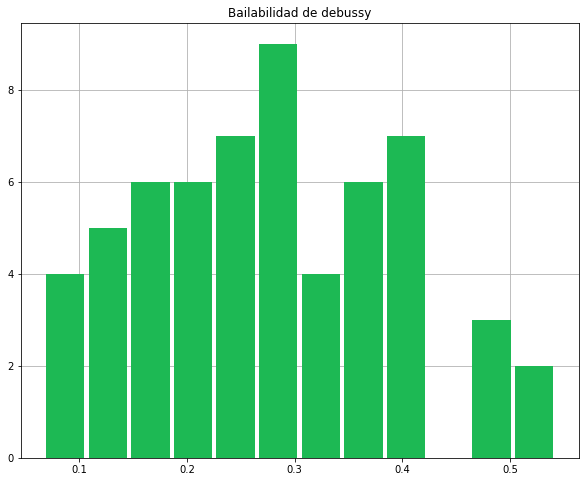

In [ ]:
# Veamos el histograma de dos valores
playlist_A.hist(column='danceability', bins=12, grid=True, figsize=(10,8), color='#1DB954', zorder=2, rwidth=0.9)
plt.title("Bailabilidad de " + playlist_A_shortname)

Text(0.5, 1.0, 'Bailabilidad de jazzvibes')

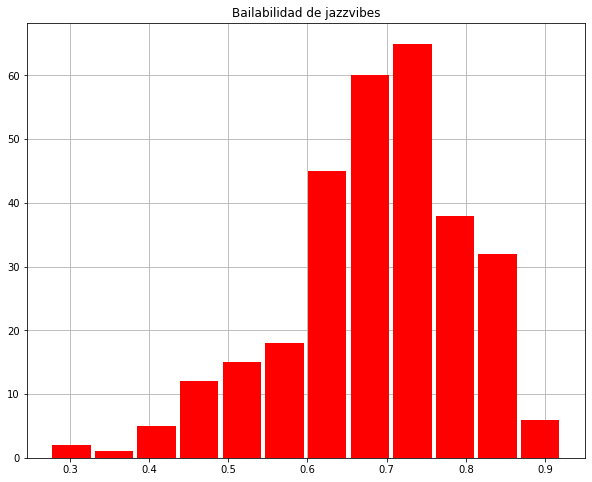

In [ ]:
playlist_B.hist(column='danceability', bins=12, grid=True, figsize=(10,8), color='red', zorder=2, rwidth=0.9)
plt.title("Bailabilidad de " + playlist_B_shortname)



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


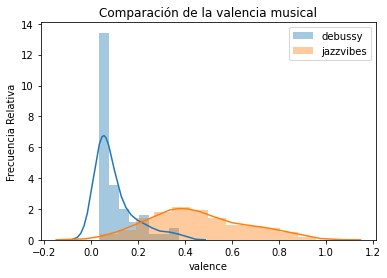

In [ ]:
# Usemos seaborn para combinar varios histogramas

sns.distplot(playlist_A['valence'],  kde=True, label=playlist_A_shortname)
sns.distplot(playlist_B['valence'], kde=True, label=playlist_B_shortname)

plt.title("Comparación de la valencia musical")

plt.ylabel("Frecuencia Relativa")
plt.legend()


plt.show()

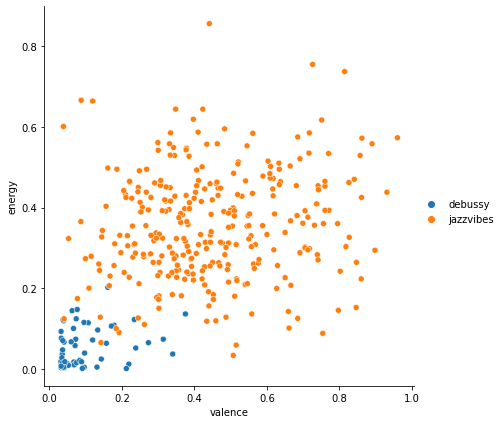

In [ ]:
g = sns.FacetGrid(playlist_juntas, height=6, aspect=1)
g.map_dataframe(sns.scatterplot, x="valence", y="energy", hue="playlist")
g.add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


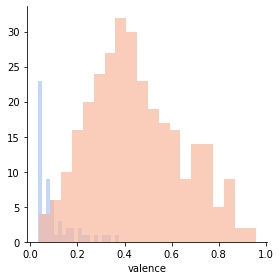

In [ ]:
g = sns.FacetGrid(playlist_juntas,hue='playlist',palette='coolwarm',size=4,aspect=1)

g.map(plt.hist,'valence',bins=20,alpha=0.7,)

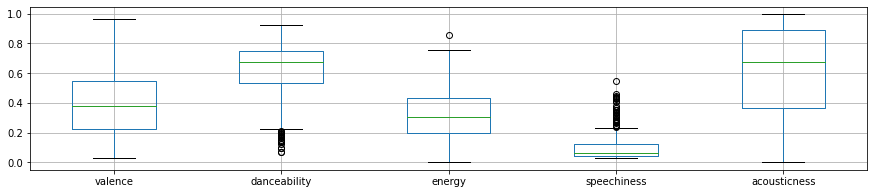

In [ ]:
playlist_A.boxplot(column=['valence', 'danceability', 'energy', 'speechiness', 'acousticness', ],figsize=(15,3));

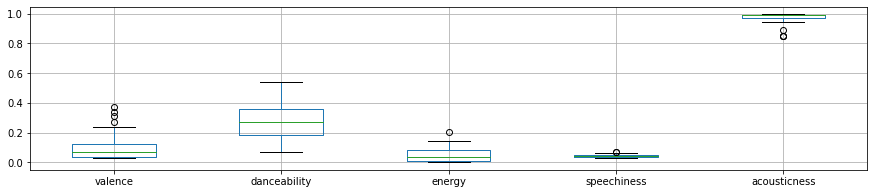

In [ ]:
playlist_A.boxplot(column=['valence', 'danceability', 'energy', 'speechiness', 'acousticness', ],figsize=(15,3));

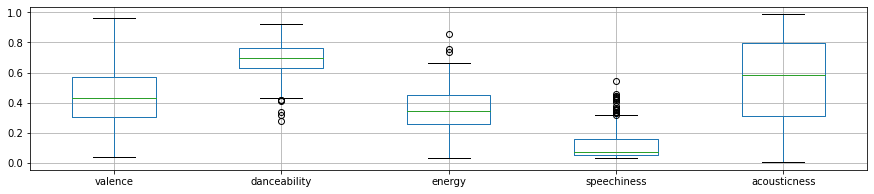

In [ ]:
playlist_B.boxplot(column=['valence', 'danceability', 'energy', 'speechiness', 'acousticness', ],figsize=(15,3));

**Exploremos las medias de cada caracteristica**

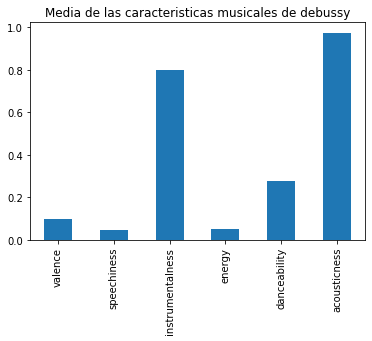

In [ ]:
plt.title("Media de las caracteristicas musicales de " + playlist_A_shortname)
playlist_A[columnas].mean().plot(kind='bar')

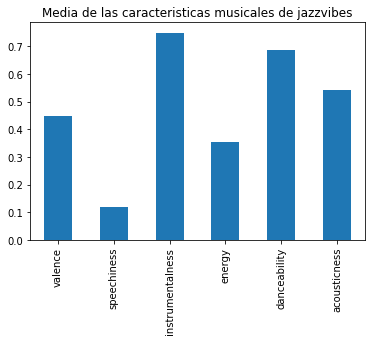

In [ ]:
plt.title("Media de las caracteristicas musicales de " + playlist_B_shortname)
playlist_B[columnas].mean().plot(kind='bar')

**¿Puedo hacer un resumen de la media de cada una de las caracteristicas de los playlist?**

In [21]:
# Función para calcular la media de todas las casracteristicas de la playlist

def playlist_features_to_mean(playlist, playlist_name):
  # Podemos hacer una lista de todas las columnas que queremos obtener sumatorias
  columnas = ['valence', 'speechiness', 'instrumentalness', 'energy', 'danceability', 'acousticness']
  # Calculamos las medianas de todas las columnas
  # Transponemos los valores, columnas en filas
  mean_dataframe = playlist[columnas].mean().to_frame().transpose()
  # Añadimos la columna playlist para poder comparar
  mean_dataframe['playlist'] = playlist_name

  return mean_dataframe

In [22]:
playlist_A_means = playlist_features_to_mean(playlist_A, playlist_A_shortname)

In [23]:
playlist_B_means = playlist_features_to_mean(playlist_B, playlist_B_shortname)

In [24]:
playlist_A_means

,valence,speechiness,instrumentalness,energy,danceability,acousticness,playlist
0,0.097461,0.044571,0.799778,0.051533,0.275873,0.974678,debussy


In [25]:
playlist_B_means

,valence,speechiness,instrumentalness,energy,danceability,acousticness,playlist
0,0.58022,0.049204,0.133775,0.71126,0.5216,0.180825,TheBlackKeys


**¿Puedo juntar las dos dataframes?**

In [26]:
# Podemos juntar las dos medidas en un mismo dataframe
all_means = pd.concat([playlist_A_means,playlist_B_means])
all_means

,valence,speechiness,instrumentalness,energy,danceability,acousticness,playlist
0,0.097461,0.044571,0.799778,0.051533,0.275873,0.974678,debussy
0,0.580220,0.049204,0.133775,0.711260,0.521600,0.180825,TheBlackKeys


In [27]:
# el indice de las filas deberia ser el playlist
all_means = all_means.set_index('playlist')

[]

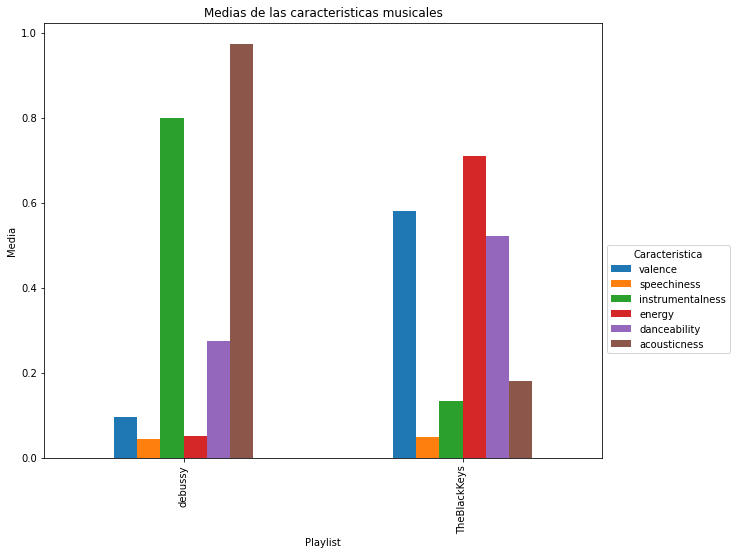

In [28]:
all_means.plot(kind='bar', figsize=(10,8))
plt.legend(loc='upper left', ncol=1, title="Caracteristica", bbox_to_anchor=(1.0, 0.5))
plt.title("Medias de las caracteristicas musicales")
plt.xlabel("Playlist")
plt.ylabel("Media")
plt.plot()

**Podemos usar transpose para cambiar los ejes de la tabla y del chart**

In [33]:
all_means.transpose()

playlist,debussy,TheBlackKeys
valence,0.097461,0.580220
speechiness,0.044571,0.049204
instrumentalness,0.799778,0.133775
energy,0.051533,0.711260
danceability,0.275873,0.521600
acousticness,0.974678,0.180825


[]

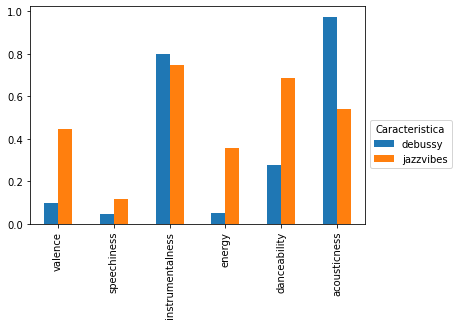

In [ ]:
all_means.transpose().plot(kind='bar')
plt.legend(loc='upper left', ncol=1, title="Caracteristica", bbox_to_anchor=(1.0, 0.5))
plt.plot()

# Ejercicio
Unifica todos los **playlists** en un unico playlit llamado **allplaylist** con una nueva columna que tenga el nombre del playlist

In [ ]:
allplaylist =

In [ ]:

sns.boxplot(y=allplaylist['valence'], x=allplaylist['playlist']) 

plt.show()

In [ ]:
ax = sns.boxplot(data=allplaylist, x=allplaylist['popularity'], orient="h", y="playlist")

In [ ]:
allplaylist.boxplot(column=['popularity', ], by='playlist', figsize=(10,6),  fontsize=12);
plt.show()

In [ ]:

allplaylist.boxplot(column=['energy', 'acousticness','valence', 'danceability' ], by='playlist', figsize=(30,9) );
plt.show()

In [ ]:
# Un scatter puede tener una tercera variable
plt.figure(figsize=(10,10), dpi=120)

allplaylist.plot.scatter(  x='valence',
                          y='danceability',
                         c='popularity',
                         by='playlist',
                                colormap='viridis',
                        
                              )

In [ ]:
plt.figure(figsize=(10,10), dpi=120)

sns.scatterplot(x="energy", y="popularity", data=allplaylist, hue="playlist", style="playlist")


ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/tracks/-f with Params: {'market': None} returned 400 due to invalid id


SpotifyException: ignored